Checking whether dark dresses could be observed at earth-based interferometers.

In [50]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import pickle
from typing import Callable, Dict, Tuple

import dynesty
from dynesty import plotting as dyplot
import jax
import jax.numpy as jnp
from jax import random
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar
from tqdm.auto import tqdm, trange

from pydd.analysis import (
    loglikelihood_cut,
    calculate_SNR_cut,
    calculate_match_unnormd_cut,
)
# from pydd.analysis import loglikelihood, calculate_SNR, calculate_match_unnormd
from pydd.binary import *
from pydd.noise import *

rho_s_pbh = 1.798e4 * MSUN / PC ** 3
gamma_s_pbh = 9 / 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
S_n, f_range = S_n_aLIGO, f_range_aLIGO
fs = jnp.linspace(*f_range, 100_000)

m_1 = 1 * MSUN
m_2 = 1e-3 * MSUN
M_chirp = get_M_chirp(m_1, m_2)
q = m_2 / m_1
rho_s = rho_s_pbh
gamma_s = gamma_s_pbh
rho_6 = get_rho_6(rho_s, m_1, gamma_s)
tT_c = jnp.array(0.0)
f_c = get_f_isco(m_1)
_dd_d = DynamicDress(
    gamma_s,
    rho_6,
    get_M_chirp(m_1, m_2),
    m_2 / m_1,
    jnp.array(0.0),
    tT_c=tT_c,
    dL=100e6 * PC,
    f_c=get_f_isco(m_1),
)

# Get f_range
t_obs = 1 * YR
f_range_d = get_f_range(_dd_d, t_obs)
# Get dL
snr_thresh = 12.0
_fn = jax.jit(
    lambda dL: calculate_SNR_cut(
        DynamicDress(
            _dd_d.gamma_s,
            _dd_d.rho_6,
            _dd_d.M_chirp,
            _dd_d.q,
            _dd_d.Phi_c,
            _dd_d.tT_c,
            dL,
            _dd_d.f_c,
        ),
        f_range_d,
        fs,
        S_n,
    )
)
res = root_scalar(
    lambda dL: (_fn(dL) - snr_thresh), bracket=(0.1e6 * PC, 100000e6 * PC)
)
assert res.converged
dL = res.root

dd_d = DynamicDress(
    _dd_d.gamma_s,
    _dd_d.rho_6,
    _dd_d.M_chirp,
    _dd_d.q,
    _dd_d.Phi_c,
    _dd_d.tT_c,
    dL,
    _dd_d.f_c,
)


@jax.jit
def ll_cut_fn(dd_h, f_range_h):
#     return loglikelihood(dd_h, dd_d, fs, S_n)
    return loglikelihood_cut(dd_h, dd_d, f_range_h, f_range_d, fs, S_n)

In [9]:
%timeit ll_cut_fn(dd_d, f_range_d)

61.4 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
def ll_fn(x):
    # Make template
    M_chirp_MSUN, tT_c = x
    M_chirp = M_chirp_MSUN * MSUN
    m_1 = get_m_1(M_chirp, dd_d.q)
    rho_6 = get_rho_6(rho_s, m_1, dd_d.gamma_s)
    f_c = get_f_isco(m_1)
    dd_h = DynamicDress(
        dd_d.gamma_s, rho_6, M_chirp, dd_d.q, dd_d.Phi_c, tT_c, dd_d.dL, f_c
    )

    f_range_h = get_f_range(dd_h, t_obs)

    return ll_cut_fn(dd_h, f_range_h)

In [11]:
%timeit ll_fn(jnp.array([M_chirp / MSUN, 0.0]))

143 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
# 2D: (Mc, tT_c)
# Without cutting
M_chirp_MSUN_range = jnp.array([
    dd_d.M_chirp / MSUN * (1 - 3e-8),
    dd_d.M_chirp / MSUN * (1 + 3e-8)
])
tT_c_range = jnp.array([-0.0002, 0.0002])


def ptform(u):
    M_chirp_MSUN = (M_chirp_MSUN_range[1] - M_chirp_MSUN_range[0]) * u[
        0
    ] + M_chirp_MSUN_range[0]
    tT_c = (tT_c_range[1] - tT_c_range[0]) * u[1] + tT_c_range[0]
    return jnp.array([M_chirp_MSUN, tT_c])

In [58]:
(
    ll_fn(jnp.array([dd_d.M_chirp / MSUN, dd_d.tT_c])),
    ll_fn(jnp.array([dd_d.M_chirp / MSUN, tT_c_range[0]])),
    ll_fn(jnp.array([M_chirp_MSUN_range[0], dd_d.tT_c])),
)

(DeviceArray(72., dtype=float64),
 DeviceArray(69.96584583, dtype=float64),
 DeviceArray(67.48063054, dtype=float64))

In [32]:
key = random.PRNGKey(50)

key, subkey = random.split(key)
us = random.uniform(subkey, shape=(2, 800))
vs = ptform(us).T
lls = np.zeros(len(vs))
for i in trange(len(vs)):
    lls[i] = ll_fn(vs[i])

lls = jnp.array(lls) - lls.min()

  0%|          | 0/800 [00:00<?, ?it/s]

Text(0, 0.5, '$\\tilde{t}_c$ [s]')

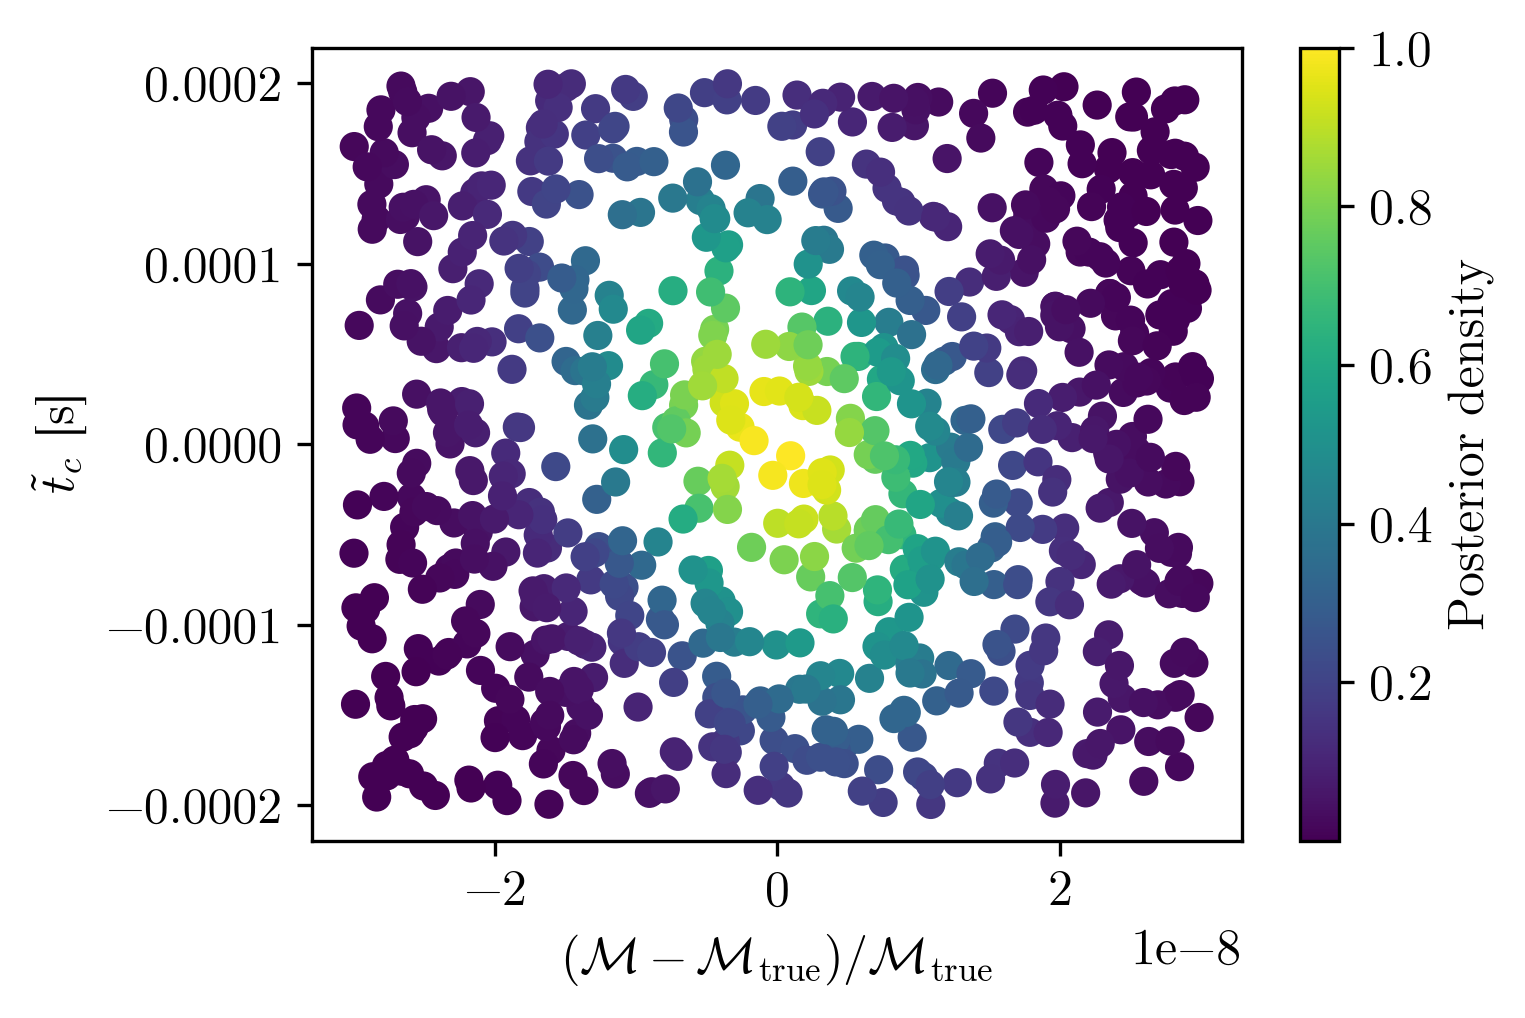

In [15]:
xys = (vs - jnp.array([dd_d.M_chirp / MSUN, 0.])) / jnp.array([dd_d.M_chirp / MSUN, 1.])
plt.scatter(*xys.T, c=jnp.exp(lls) / jnp.exp(lls).max())
plt.colorbar(label="Posterior density")
plt.xlabel(r"$(\mathcal{M} - \mathcal{M}_\mathrm{true}) / \mathcal{M}_\mathrm{true}$")
plt.ylabel(r"$\tilde{t}_c$ [s]")

Maximize over $\tilde{t}_c$

In [17]:
def ll_fn(x):
    # Make template
    M_chirp_MSUN = x
    M_chirp = M_chirp_MSUN * MSUN
    m_1 = get_m_1(M_chirp, dd_d.q)
    rho_6 = get_rho_6(rho_s, m_1, dd_d.gamma_s)
    f_c = get_f_isco(m_1)
    
    def _nll(tT_c):
        dd_h = DynamicDress(
            dd_d.gamma_s, rho_6, M_chirp, dd_d.q, dd_d.Phi_c, tT_c, dd_d.dL, f_c
        )
        f_range_h = get_f_range(dd_h, t_obs)
        return -ll_cut_fn(dd_h, f_range_h)
    
    dtT_c = jnp.array(1e-3)
    res = minimize_scalar(_nll, bracket=(-dtT_c, dtT_c)
    assert res.success, res
    return res.fun

In [18]:
%timeit ll_fn(jnp.array(dd_d.M_chirp / MSUN))

1.66 s ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Stuff below here may be indecipherable or broken.

Looking at the frequency range for different systems

In [7]:
def _fn(x):
    # Make template
    M_chirp_MSUN, tT_c = x
    M_chirp = M_chirp_MSUN * MSUN
    m_1 = get_m_1(M_chirp, q)
    rho_6 = get_rho_6(rho_s, m_1, gamma_s)
    f_c = get_f_isco(m_1)
    dd_h = DynamicDress(gamma_s, rho_6, M_chirp, q, 0.0, tT_c, dL, f_c)
    return get_f_range(dd_h, t_obs)

M_chirp_MSUNs = jnp.linspace(
    M_chirp / MSUN * (1 - 5e-1), M_chirp / MSUN * (1 + 5e-1), 50
)
f_ranges_1 = jnp.array([_fn(jnp.array([Mc_MS, 0.0])) for Mc_MS in M_chirp_MSUNs])
f_ranges_2 = jnp.array([_fn(jnp.array([Mc_MS, 10.0])) for Mc_MS in M_chirp_MSUNs])

Text(0.5, 1.0, '$t_\\mathrm{obs} = 1 \\, \\mathrm{yr}$')

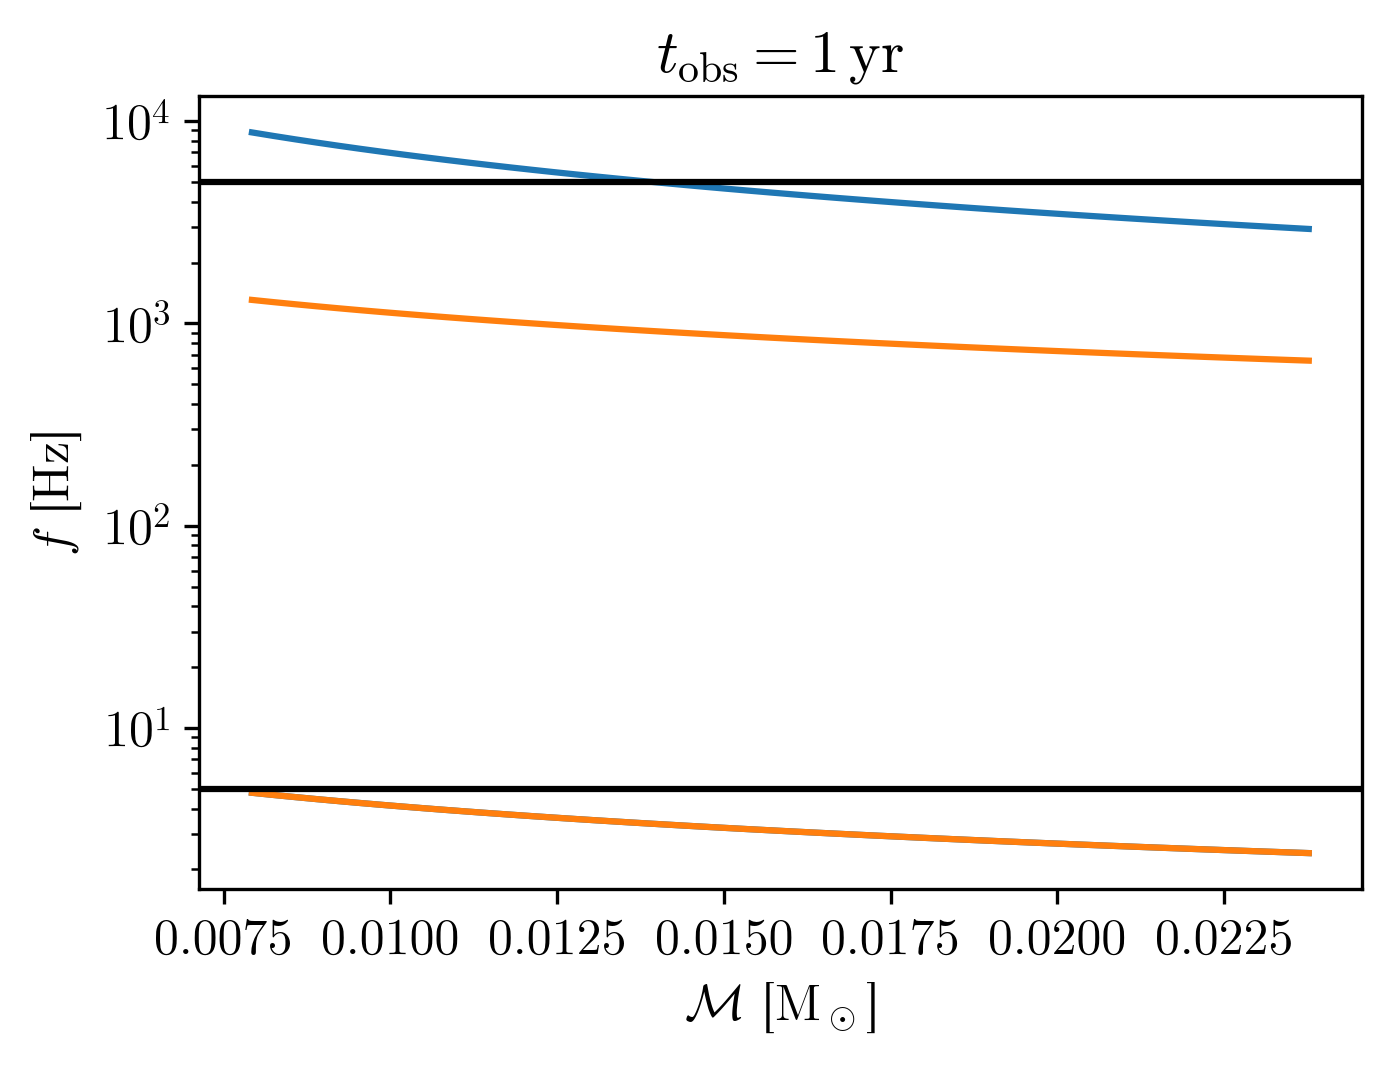

In [23]:
for i, f_ranges in enumerate([f_ranges_1, f_ranges_2]):
    for fr in f_ranges.T:
        plt.plot(M_chirp_MSUNs, fr, c=f"C{i}")

# plt.axhline(get_f_b(m_1, m_2, gamma_s), color="k")
# plt.axvline(M_chirp / MSUN, color="k")
plt.yscale("log")
plt.axhline(f_range[0], c="k")
plt.axhline(f_range[1], c="k")
plt.xlabel(r"$\mathcal{M}$ [M$_\odot$]")
plt.ylabel(r"$f$ [Hz]")
plt.title(r"$t_\mathrm{obs} = %g \, \mathrm{yr}$" % (t_obs / YR))

## NS

In [8]:
# 2D: (Mc, tT_c)
# Parameter ranges
M_chirp_MSUN_range = (
    dd_s.M_chirp / MSUN * (1 - 2.5e-3),
    dd_s.M_chirp / MSUN * (1 + 2.5e-3),
)
tT_c_range = (-0.0008, 0.0008)


def ptform(u):
    M_chirp_MSUN = (M_chirp_MSUN_range[1] - M_chirp_MSUN_range[0]) * u[
        0
    ] + M_chirp_MSUN_range[0]
    tT_c = (tT_c_range[1] - tT_c_range[0]) * u[1] + tT_c_range[0]
    return jnp.array([M_chirp_MSUN, tT_c])


def get_ll_fn(dd_s, rho_s, gamma_s, fs, S_n):
    """
    x: parameter point
    dd_s: signal system
    """

    def _ll(x):
        # Unpack parameters into dark dress ones
        M_chirp_MSUN, tT_c = x
        M_chirp = M_chirp_MSUN * MSUN
        m_1 = get_m_1(M_chirp, dd_s.q)
        m_2 = get_m_2(M_chirp, dd_s.q)
        rho_6 = get_rho_6(rho_s, m_1, dd_s.gamma_s)
        f_c = get_f_isco(m_1)
        dd_h = DynamicDress(
            dd_s.gamma_s,
            rho_6,
            dd_s.M_chirp,
            dd_s.q,
            dd_s.Phi_c,
            tT_c,
            dd_s.dL,
            f_c,
        )

        return loglikelihood(dd_h, dd_s, fs, S_n)

    return _ll

ll_fn = jax.jit(get_ll_fn(dd_s, rho_s, gamma_s, fs, S_n))

In [14]:
vs = ptform(np.random.rand(2, 500)).T
lls = np.zeros(len(vs))
for i in trange(len(vs)):
    lls[i] = ll_fn(vs[i])

lls = jnp.array(lls)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, '$\\tilde{t}_c$ [s]')

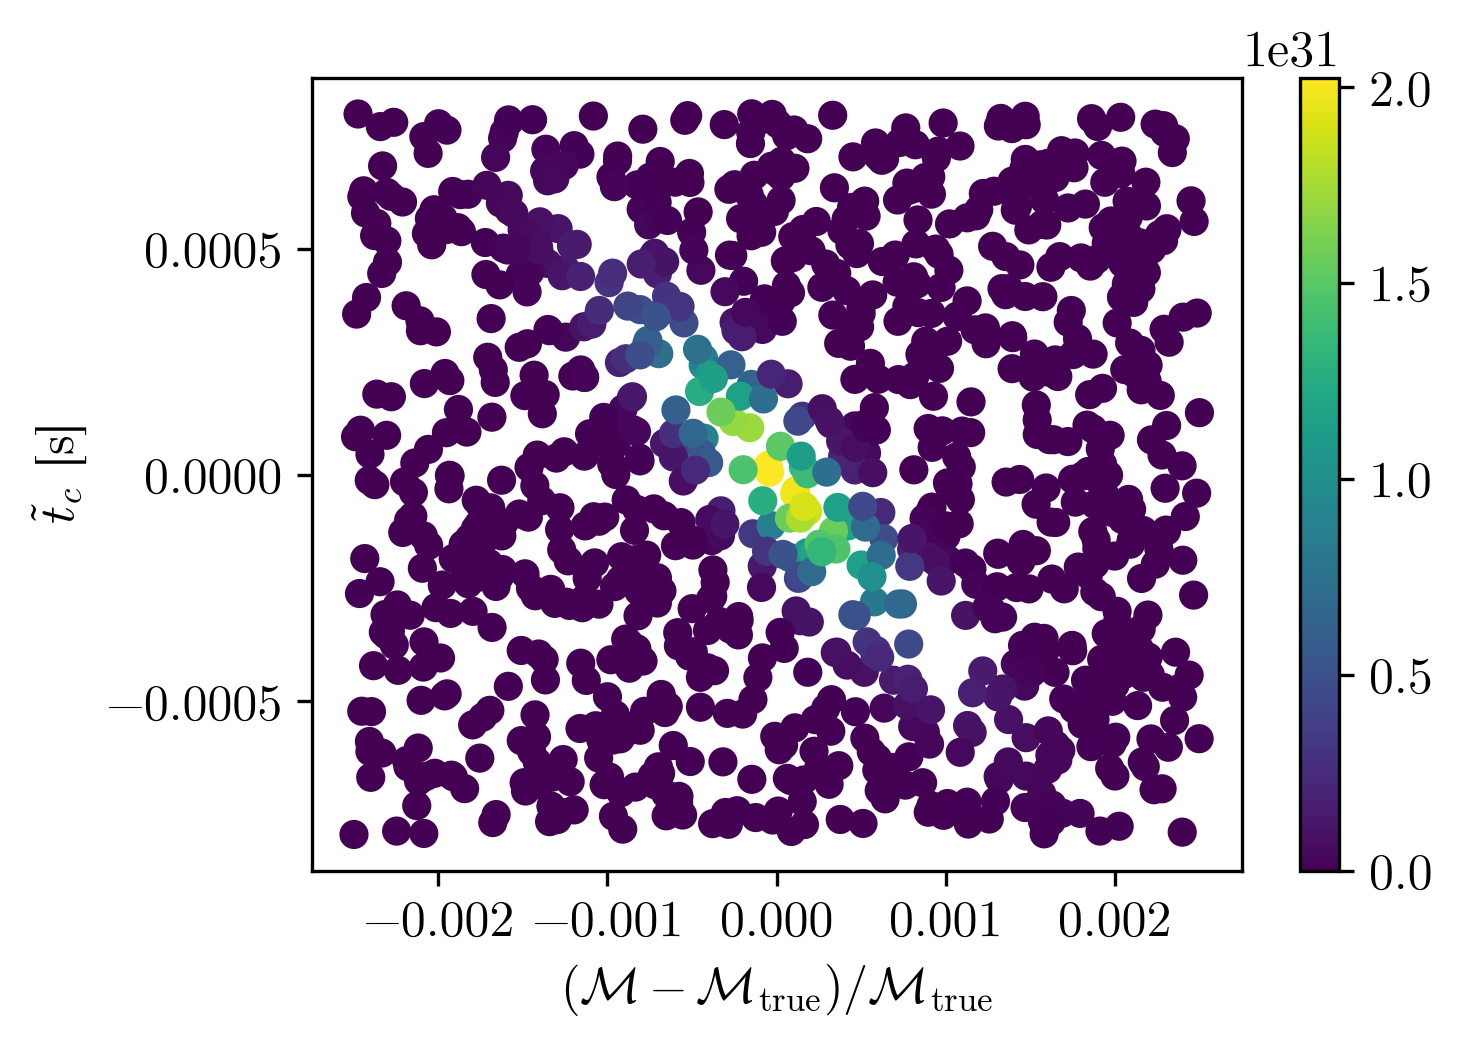

In [36]:
xys = (vs - jnp.array([dd_s.M_chirp / MSUN, 0.])) / jnp.array([dd_s.M_chirp / MSUN, 1.])
plt.scatter(*xys.T, c=jnp.exp(lls))
plt.colorbar()
plt.xlabel(r"$(\mathcal{M} - \mathcal{M}_\mathrm{true}) / \mathcal{M}_\mathrm{true}$")
plt.ylabel(r"$\tilde{t}_c$ [s]")

Run `dynesty` for dark dress

In [17]:
# Run
sampler = dynesty.NestedSampler(ll_fn, ptform, 2, nlive=500)
sampler.run_nested()
results = sampler.results

471it [00:31,  7.44it/s, bound: 0 | nc: 7 | ncall: 1279 | eff(%): 36.826 | loglstar:   -inf < 49.195 <    inf | logz: 45.018 +/-  0.111 | dlogz: 26.129 >  0.509] Traceback (most recent call last):
  File "/Users/acoogan/.pyenv/versions/3.9.1/envs/dd-3.9.1/lib/python3.9/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
KeyboardInterrupt
473it [00:31, 14.86it/s, bound: 0 | nc: 1 | ncall: 1281 | eff(%): 36.924 | loglstar:   -inf < 49.323 <    inf | logz: 45.124 +/-  0.111 | dlogz: 26.020 >  0.509]

Exception while calling loglikelihood function:
  params: [ 0.01587234 -0.00039873]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# Plot
M_chirp = get_M_chirp(m_1, m_2)
log10_q = jnp.log10(m_2 / m_1)

labels = (r"$\mathcal{M}$ [M$_\odot$]", r"$\tilde{t}_c$ [s]")
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
cfig = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    truths=(M_chirp / MSUN, dd_s.tT_c),
    show_titles=True,
    title_fmt=".2g"
)[0]
cfig.suptitle(
    r"$m_1 = %g\, \mathrm{M}_\odot, \, m_2 = %g\, \mathrm{M}_\odot$"
    % (m_1 / MSUN, m_2 / MSUN)
)
cfig.tight_layout()
cfig.savefig(f"figures/post_aLIGO_m1={(m_1 / MSUN):g}Msun-Mc_tTc.pdf")

In [10]:
# 2D: (Mc, log10(q))
base_path = f"m1={(m_1 / MSUN):g}_m2={(m_2 / MSUN):g}"

# Parameter ranges
M_chirp_MSUN_range = (
    dd_s.M_chirp / MSUN * (1 - 1e-6),
    dd_s.M_chirp / MSUN * (1 + 1e-6),
)
log10_q_range = (-3.25, -2.75)


def ptform(u):
    M_chirp_MSUN = (M_chirp_MSUN_range[1] - M_chirp_MSUN_range[0]) * u[
        0
    ] + M_chirp_MSUN_range[0]
    log10_q = (log10_q_range[1] - log10_q_range[0]) * u[1] + log10_q_range[0]
    return jnp.array([M_chirp_MSUN, log10_q])


def get_ll_fn(dd_s, rho_s, gamma_s, fs, S_n):
    """
    x: parameter point
    dd_s: signal system
    """
    def _ll(x):
        # Unpack parameters into dark dress ones
        M_chirp_MSUN, log10_q = x
        M_chirp = M_chirp_MSUN * MSUN
        q = 10 ** log10_q
        m_1 = get_m_1(M_chirp, q)
        m_2 = get_m_2(M_chirp, q)
        rho_6 = get_rho_6(rho_s, m_1, gamma_s)
        f_c = get_f_isco(m_1)

        dd_h = DynamicDress(
            gamma_s_pbh, rho_6, M_chirp, q, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, f_c
        )

        return loglikelihood(dd_h, dd_s, fs, S_n)
    
    return _ll

Run `dynesty` for dark dress

In [17]:
# Run
sampler = dynesty.NestedSampler(ll_fn, ptform, 2, nlive=500)
sampler.run_nested()
results = sampler.results

471it [00:31,  7.44it/s, bound: 0 | nc: 7 | ncall: 1279 | eff(%): 36.826 | loglstar:   -inf < 49.195 <    inf | logz: 45.018 +/-  0.111 | dlogz: 26.129 >  0.509] Traceback (most recent call last):
  File "/Users/acoogan/.pyenv/versions/3.9.1/envs/dd-3.9.1/lib/python3.9/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
KeyboardInterrupt
473it [00:31, 14.86it/s, bound: 0 | nc: 1 | ncall: 1281 | eff(%): 36.924 | loglstar:   -inf < 49.323 <    inf | logz: 45.124 +/-  0.111 | dlogz: 26.020 >  0.509]

Exception while calling loglikelihood function:
  params: [ 0.01587234 -0.00039873]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

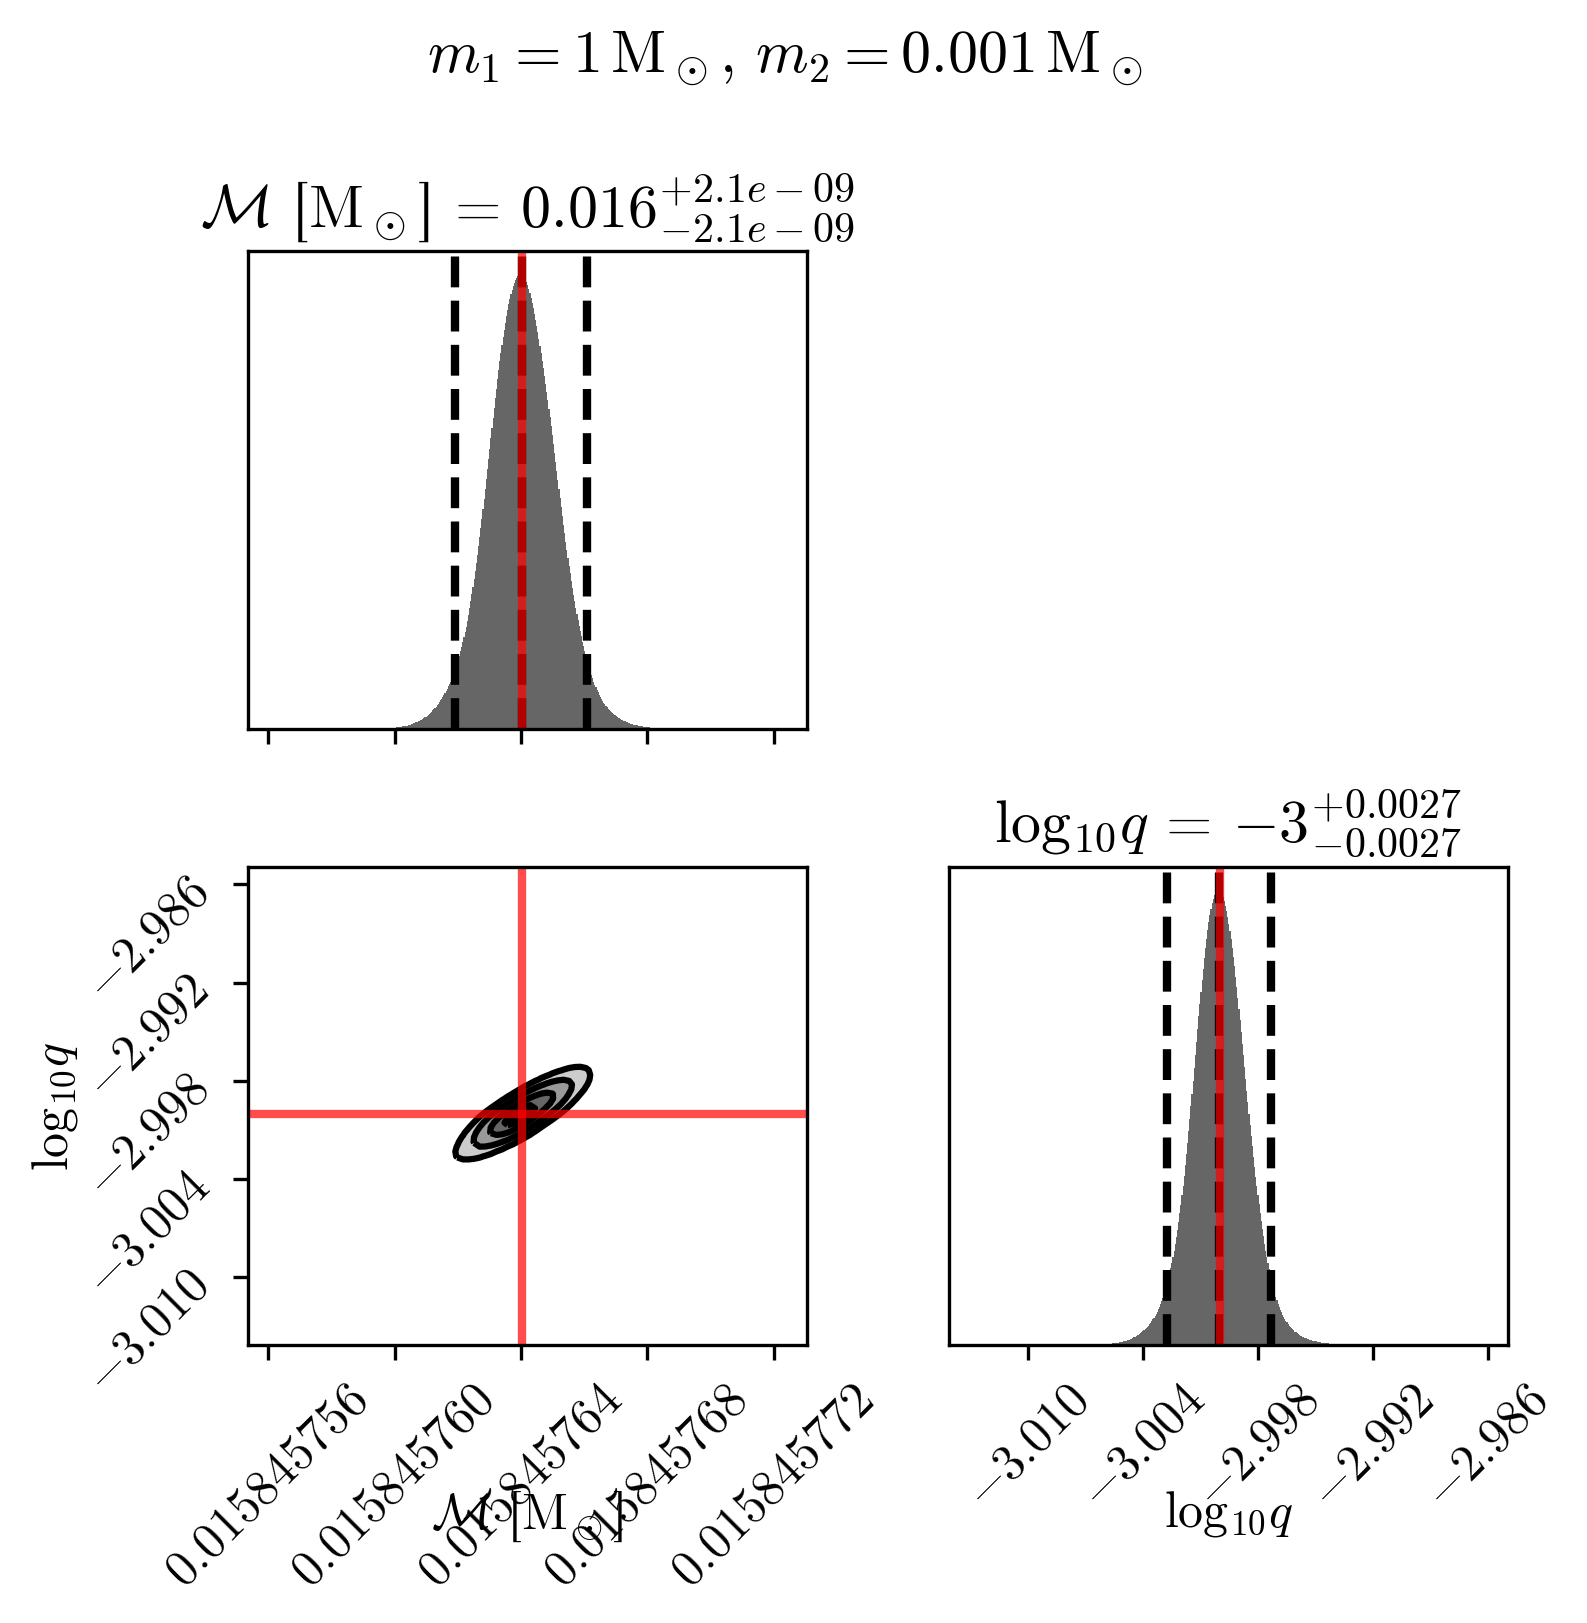

In [43]:
# Plot
M_chirp = get_M_chirp(m_1, m_2)
log10_q = jnp.log10(m_2 / m_1)

labels = (r"$\mathcal{M}$ [M$_\odot$]", r"$\log_{10} q$")
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
cfig = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    truths=(M_chirp / MSUN, log10_q),
    show_titles=True,
    title_fmt=".2g"
)[0]
cfig.suptitle(
    r"$m_1 = %g\, \mathrm{M}_\odot, \, m_2 = %g\, \mathrm{M}_\odot$"
    % (m_1 / MSUN, m_2 / MSUN)
)
cfig.tight_layout()
cfig.savefig(f"figures/post_aLIGO_m1={(m_1 / MSUN):g}Msun.pdf")

# Save
with open(f"ns/{base_path}.pkl", "wb") as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

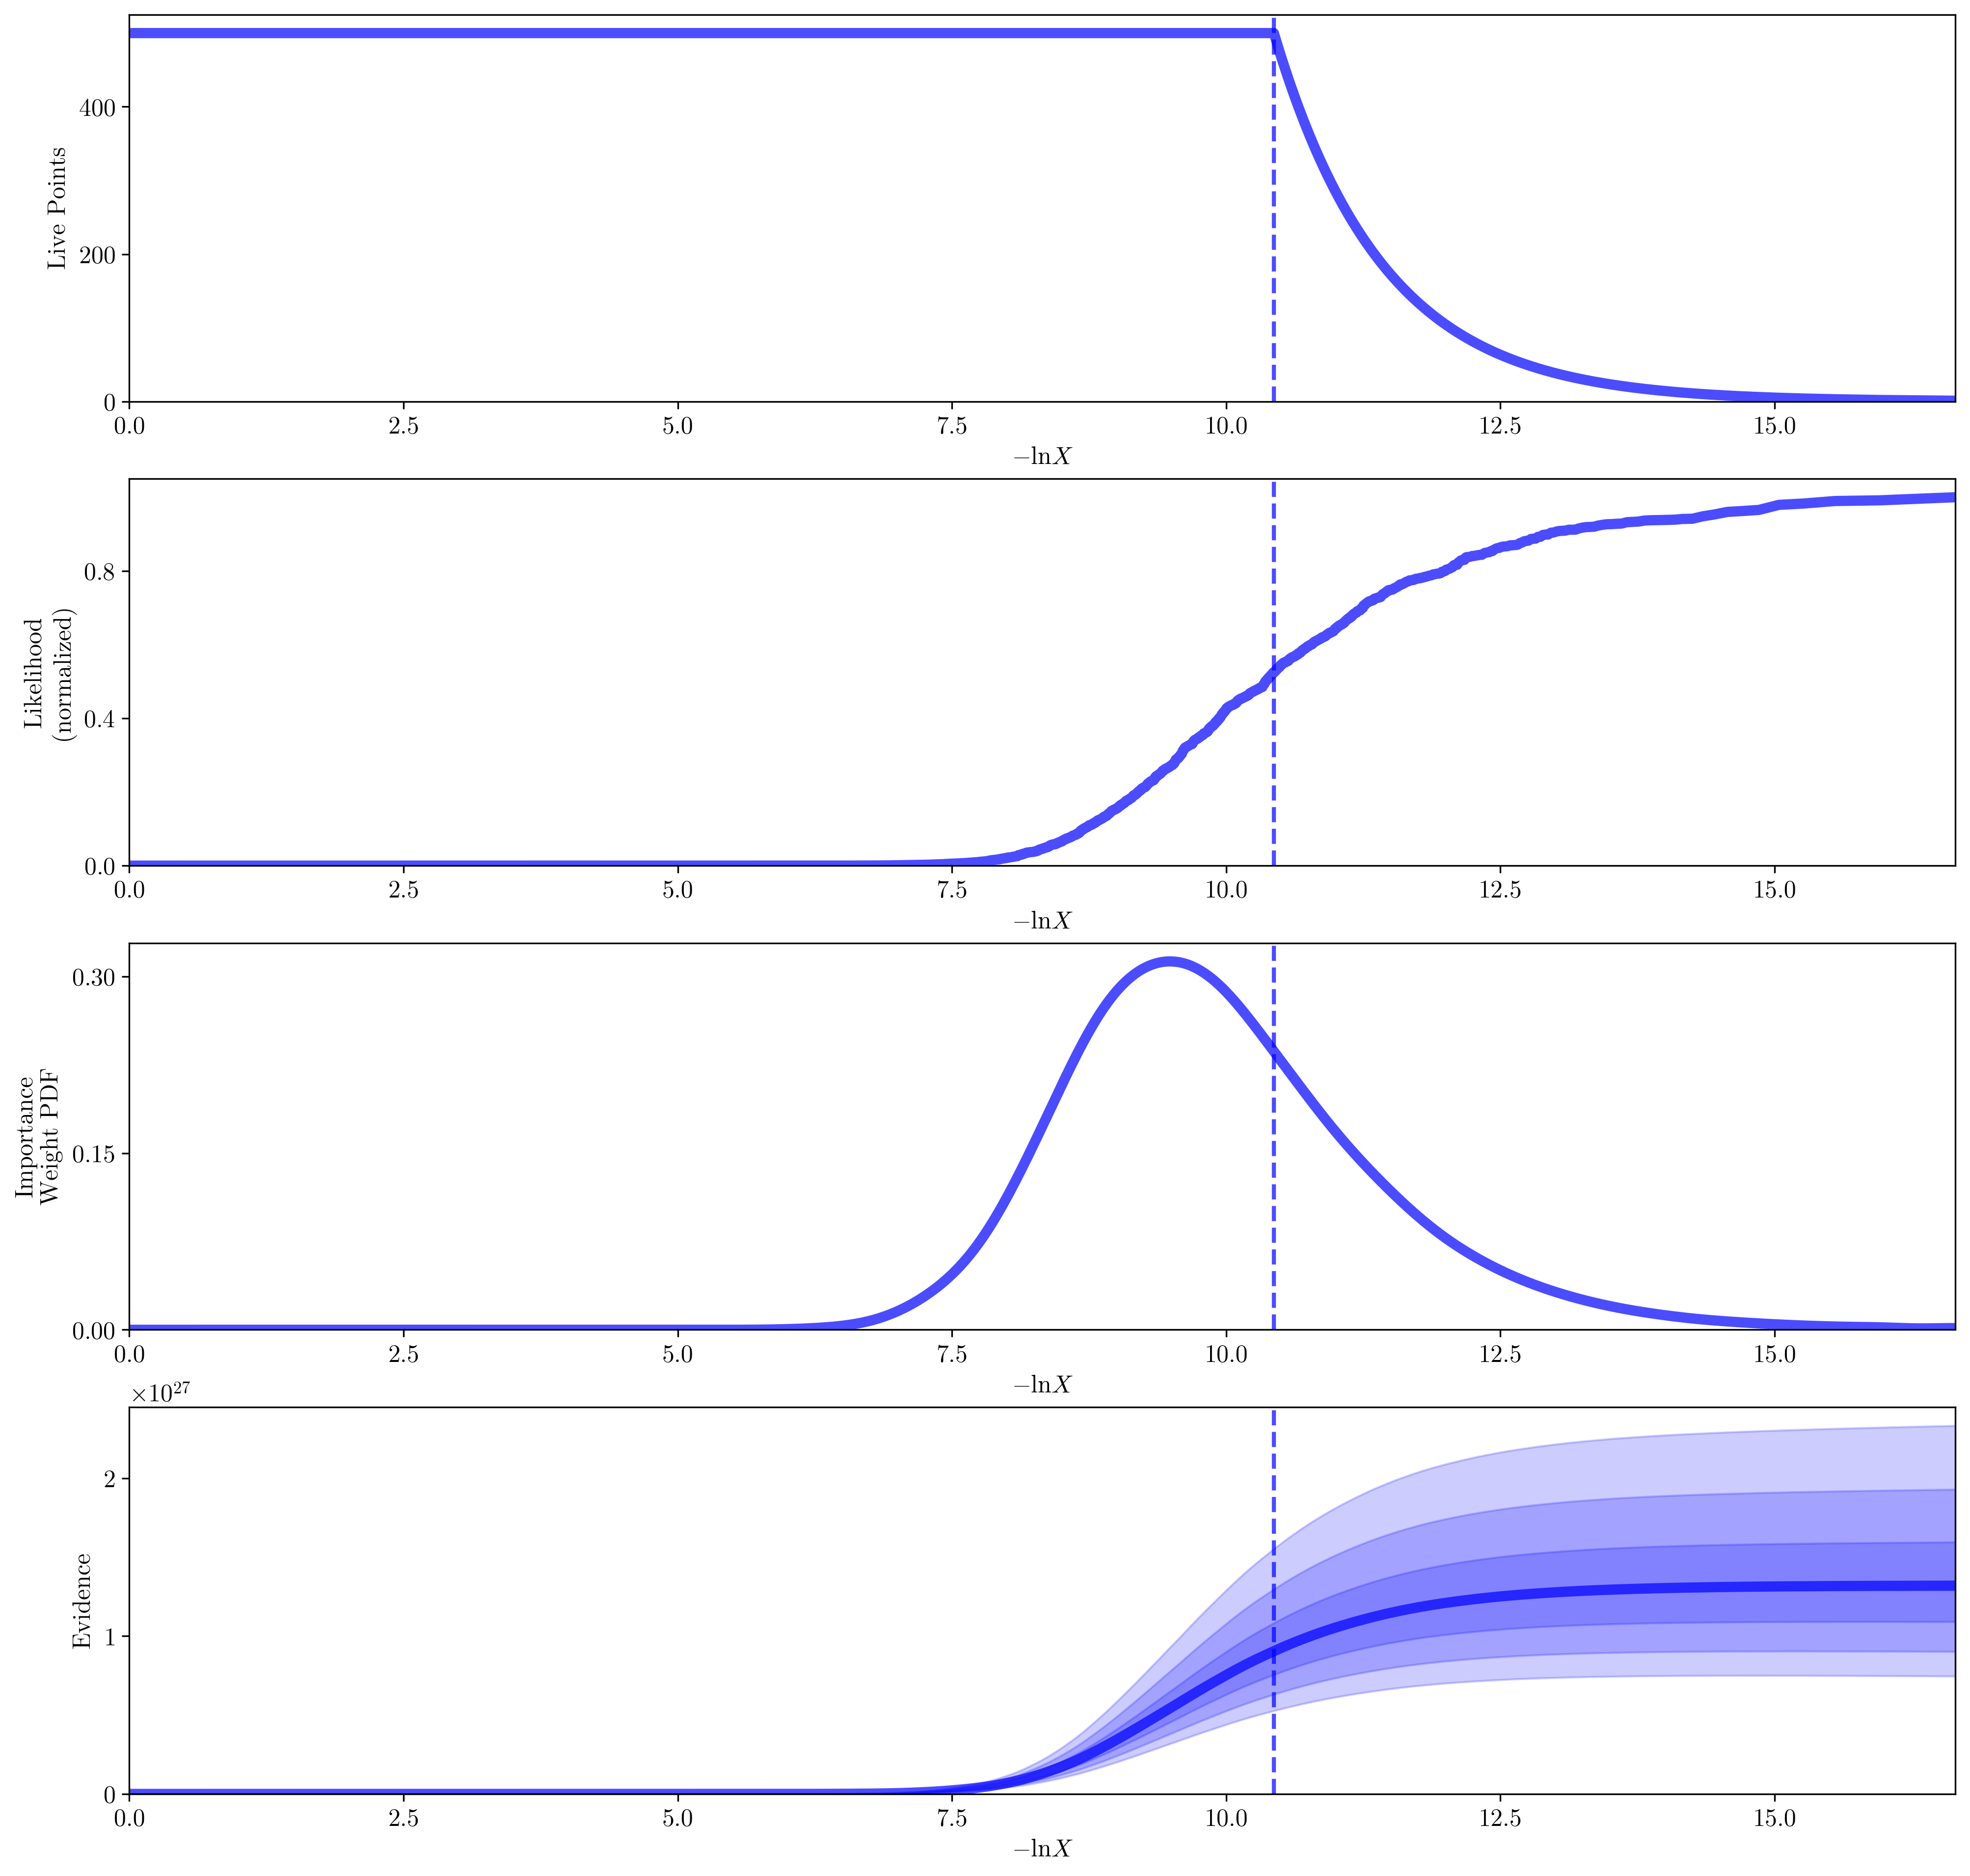

In [44]:
dyplot.runplot(results);

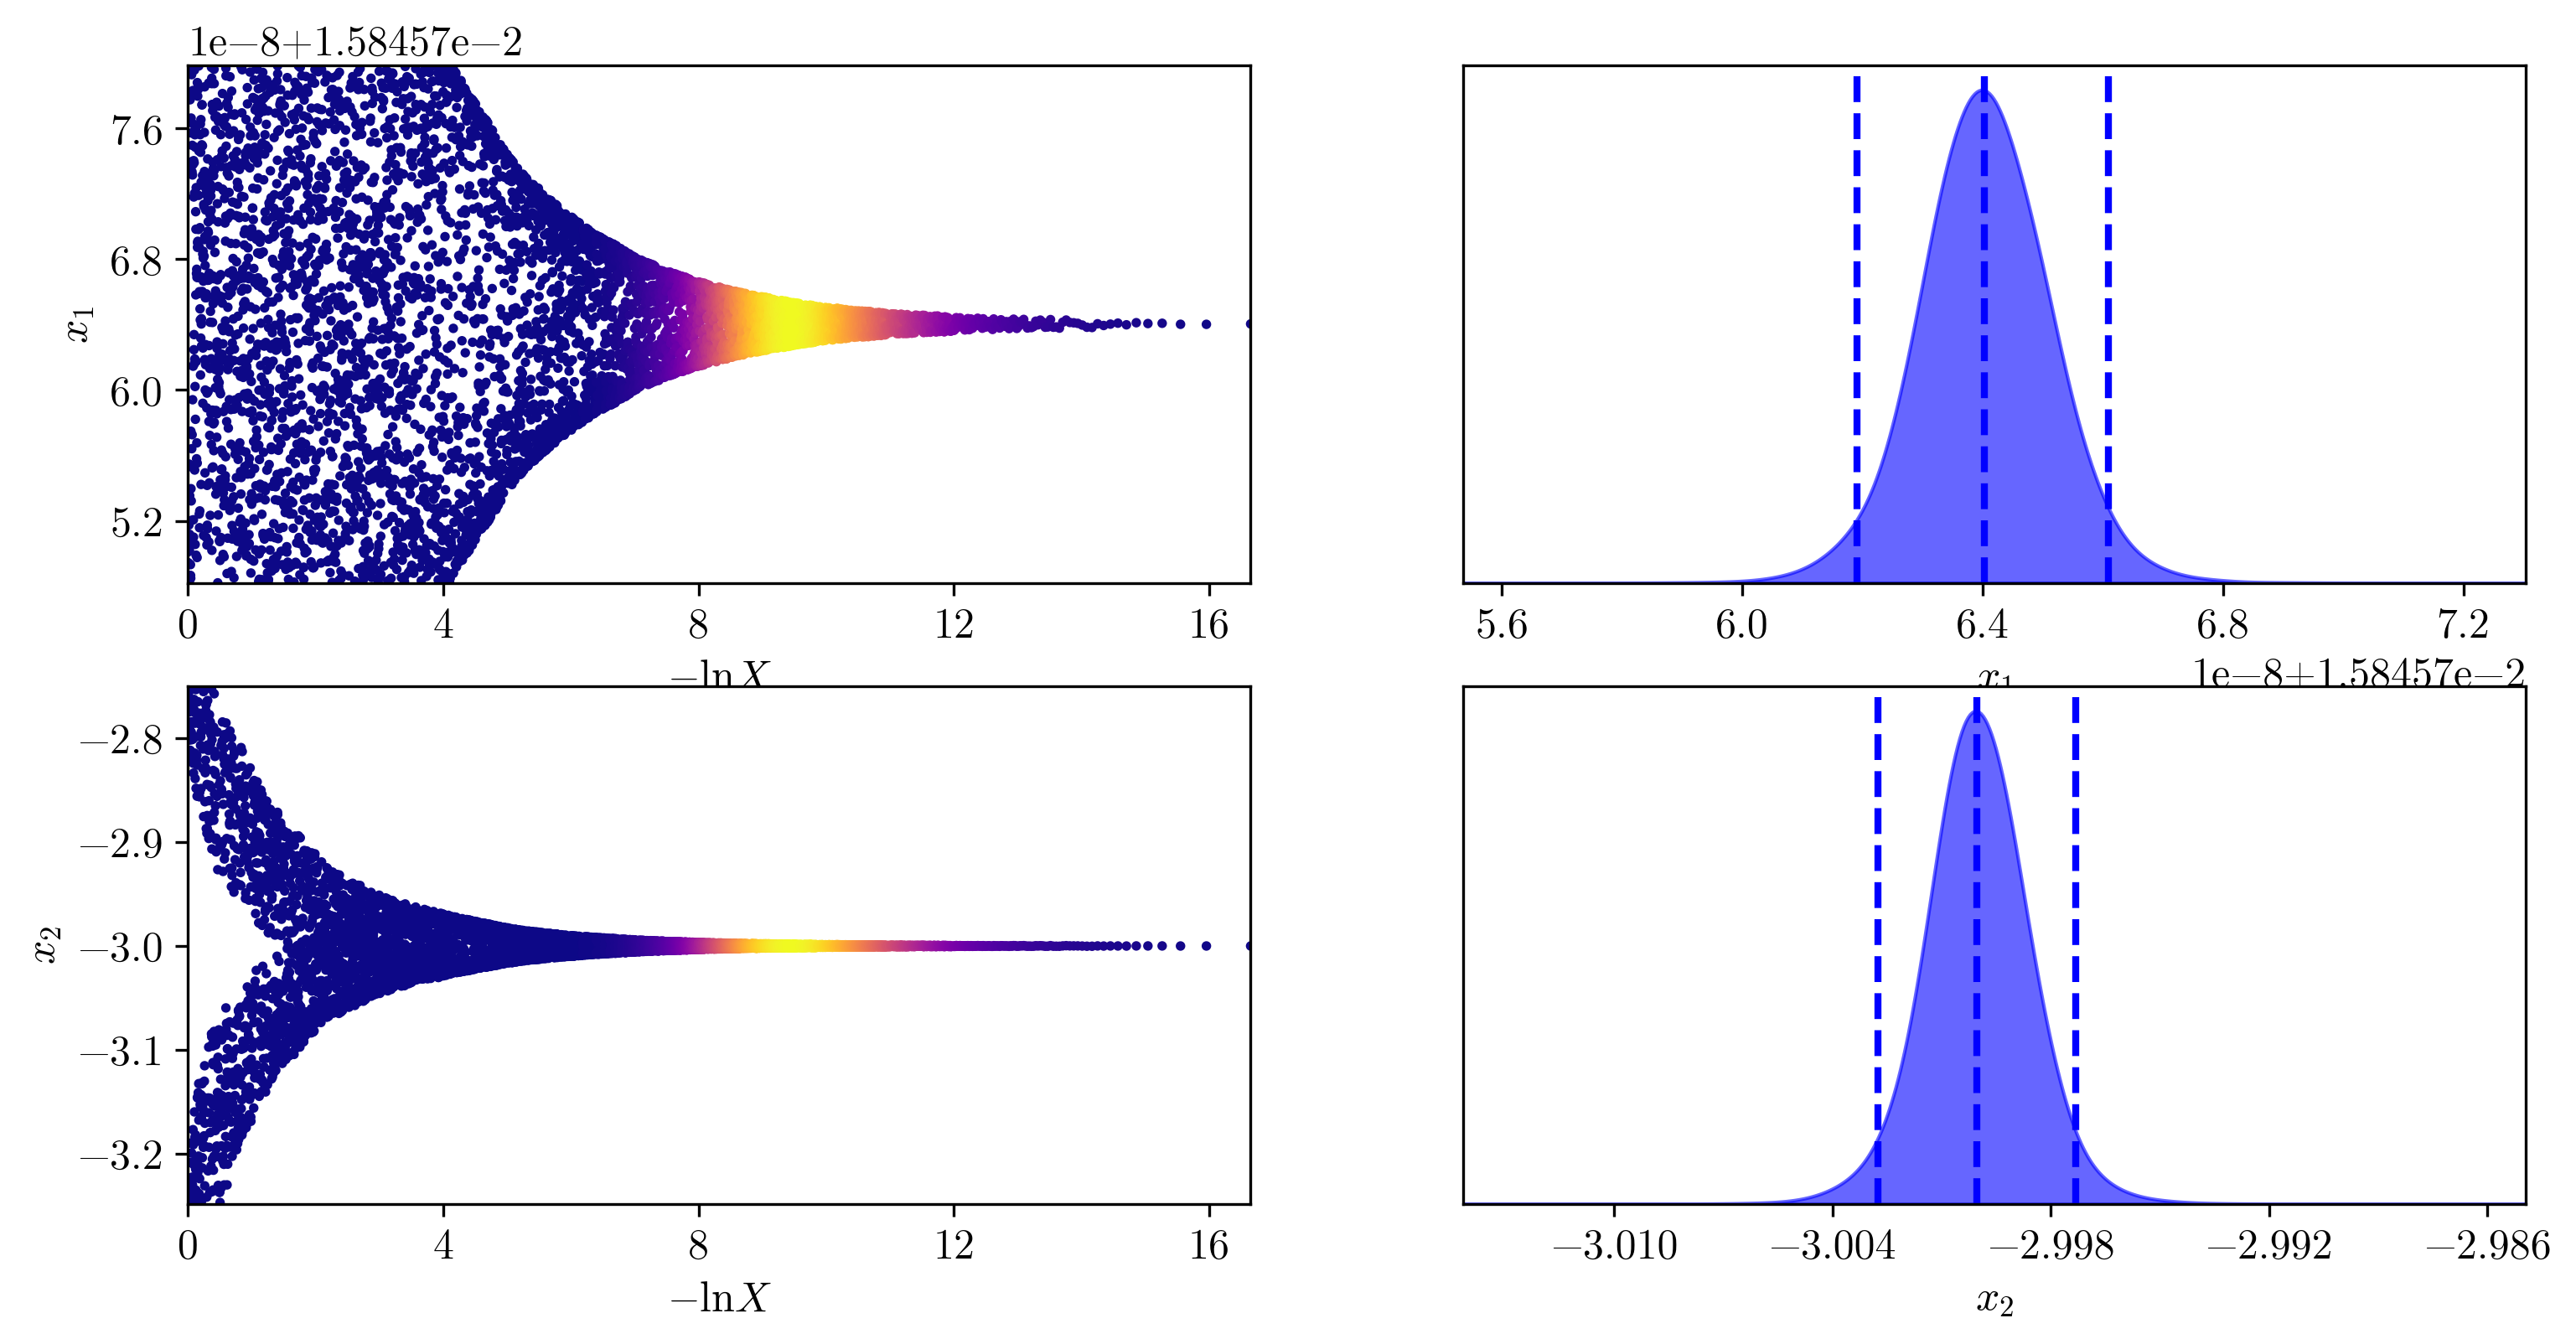

In [45]:
dyplot.traceplot(results);

Run `dynesty` for vacuum system. NOT UPDATED YET!

In [63]:
# M_chirp_MSUN_range_v = (dd_s.M_chirp / MSUN, dd_s.M_chirp / MSUN * (1 + 3e-5))
M_chirp_MSUN_range_v = (0.07922925, 0.07923025)


def ptform_v(u):
    M_chirp_MSUN = (M_chirp_MSUN_range_v[1] - M_chirp_MSUN_range_v[0]) * u[
        0
    ] + M_chirp_MSUN_range_v[0]
    return jnp.array(M_chirp_MSUN)


def get_loglikelihood_v(x, dd_s, f_l, f_h, S_n):
    """
    x: parameter point
    dd_s: signal system
    """
    # Unpack parameters into dark dress ones
    M_chirp_MSUN = x
    M_chirp = M_chirp_MSUN * MSUN
    vb_h = VacuumBinary(M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, dd_s.f_c)

    return loglikelihood_fft(vb_h, dd_s, f_l, f_h, 100000, 3000, S_n)

In [64]:
loglikelihood_v = lambda x: get_loglikelihood_v(x, dd_s, f_l, f_h, S_n)

# Run
sampler_v = dynesty.NestedSampler(loglikelihood_v, ptform_v, 1, nlive=500)
sampler_v.run_nested()
results_v = sampler_v.results

1504it [06:05,  4.11it/s, +500 | bound: 0 | nc: 1 | ncall: 10115 | eff(%): 19.812 | loglstar:   -inf < 43.797 <    inf | logz: 41.693 +/-  0.056 | dlogz:  0.001 >  0.509]


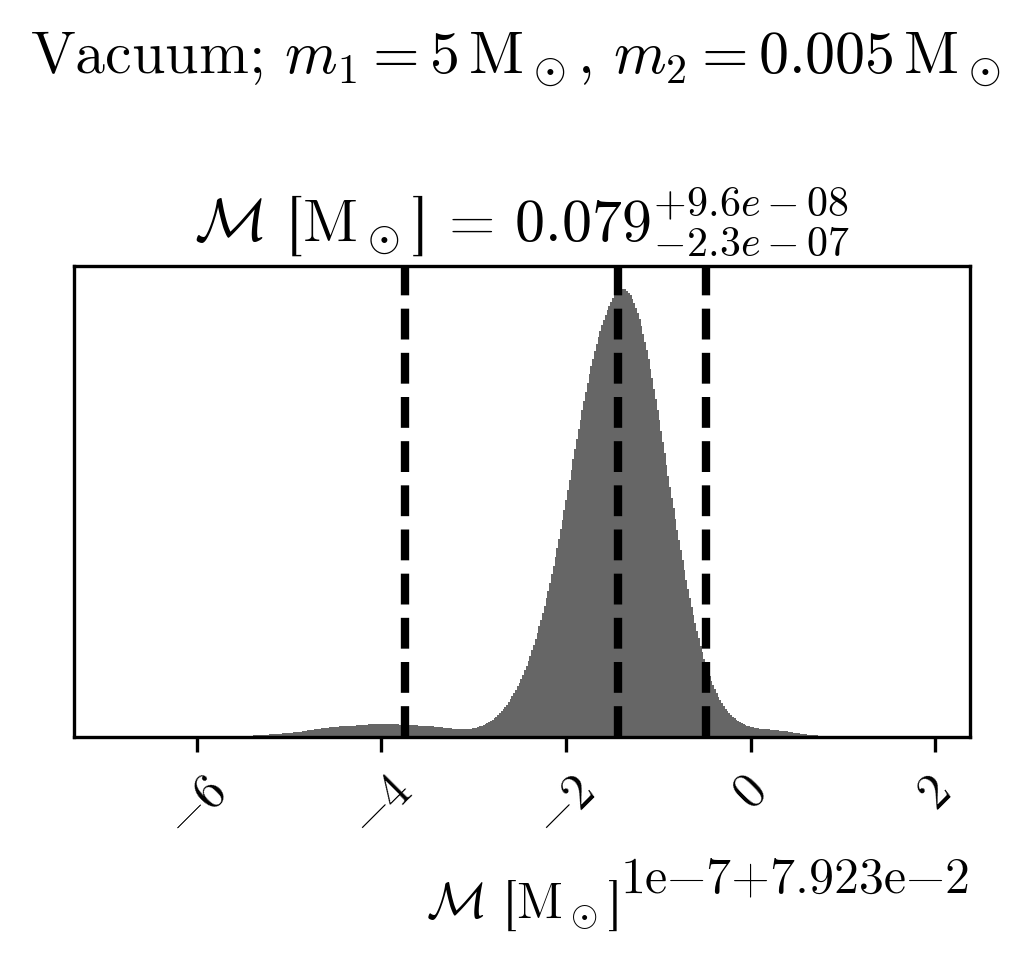

In [67]:
# Save
with open(f"ns/{base_path}_v.pkl", "wb") as output:
    pickle.dump(results_v, output, pickle.HIGHEST_PROTOCOL)

# Plot
M_chirp_MSUN_true = get_M_chirp(m_1_MSUN_true, m_2_MSUN_true)
labels_v = (r"$\mathcal{M}$ [M$_\odot$]",)
cfig = dyplot.cornerplot(
    results_v,
    labels=labels_v,
    truths=(M_chirp_MSUN_true,),
#     span=(1,),
    show_titles=True,
    title_fmt=".2g"
)[0]
cfig.suptitle(
    r"Vacuum; $m_1 = %g\, \mathrm{M}_\odot, \, m_2 = %g\, \mathrm{M}_\odot$"
    % (m_1_MSUN_true, m_2_MSUN_true)
)
cfig.tight_layout()
cfig.savefig(f"figures/corner_dynesty_2d_aLIGO_m1={m_1_MSUN_true:g}Msun_v.pdf")

Bayes factor

In [115]:
z = jnp.exp(results["logz"][-1]) * (M_chirp_MSUN_range[1] - M_chirp_MSUN_range[0]) * (log10_q_range[1] - log10_q_range[0]) / (-2.5 + 4)
z_v = jnp.exp(results_v["logz"][-1]) * (M_chirp_MSUN_range_v[1] - M_chirp_MSUN_range_v[0])
print(f"Bayes factor: {z / z_v:g}")

Bayes factor: 2.27888e+09
